#### Prerequesites:
* Define schema (make figure) 
* Define structure (make figure)
* Define schema class in python (src/models/model_schemata.py)
* Convert schema + structure into model template (models/templates/p_model.pl)

#### Procedure:
* Load data
* Adjust model script for lfi accordingly
* Create evidence file (if I don't need different evidence files, move to builmodel notebook)
* LFI

Multiple instances, 1 pst, X enzymes, one sample per instance, multiple enzymes per instance, test how many enzymes can have in one instances, how computing time depends on N p::f for 60 samples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

from src.models import model_schemata as schema
from src.models import build_model as build
from src.visualization import visualize as viz

In [3]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

#### Training/Testing

In [5]:
# reading csv from files into dict
data = {}
data['e_activity'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/e_activity.csv')
data['p_occupancy'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/p_occupancy.csv')
data['e_activity']

,enzyme,sample,value,prob
0,e1,s1,inc,0.774553
1,e1,s10,dec,0.617971
2,e1,s100,inc,0.796040
3,e1,s11,base,0.650127
4,e1,s12,dec,0.748834
...,...,...,...,...
295,e3,s95,inc,0.644811
296,e3,s96,inc,0.550137
297,e3,s97,inc,0.812202
298,e3,s98,dec,0.783041


In [14]:
# duplicate data['p_occupancy'] * n and replace p0 in the new df with pn
# use pd.concat
n = 2
new_act = data['e_activity'].copy()
for i in range(1, n):
    new_enz = data['e_activity'].loc[data['e_activity']['enzyme'] == f'e1'].copy()
    new_enz['enzyme'] = new_enz['enzyme'].replace('e1', 'e' + str(i+3))
    new_act = pd.concat([new_act, new_enz], ignore_index=True)
new_act

,enzyme,sample,value,prob
0,e1,s1,inc,0.774553
1,e1,s10,dec,0.617971
2,e1,s100,inc,0.796040
3,e1,s11,base,0.650127
4,e1,s12,dec,0.748834
...,...,...,...,...
395,e4,s95,dec,0.819472
396,e4,s96,base,0.903514
397,e4,s97,dec,0.622109
398,e4,s98,inc,0.542976


Splitting data into training/testing

In [15]:
# getting sample names (union of all samples in all datasets)
samples = list(set(data['e_activity']['sample']).union(set(data['p_occupancy']['sample'])))
samples.sort()
# sample x% of samples randomly without replacement with seed
random.seed(612)
train = random.sample(samples, int(len(samples)*0.6))
print(train)
# train = ['s1', 's2', 's3']
# filter data
training_data = {}
training_data['e_activity'] = new_act[new_act['sample'].isin(train)].reset_index(drop=True)
training_data['p_occupancy'] = data['p_occupancy'][data['p_occupancy']['sample'].isin(train)].reset_index(drop=True)

['s34', 's33', 's72', 's79', 's77', 's75', 's99', 's2', 's5', 's44', 's89', 's28', 's100', 's16', 's58', 's65', 's17', 's54', 's63', 's18', 's84', 's35', 's73', 's95', 's30', 's6', 's68', 's70', 's71', 's39', 's66', 's94', 's20', 's91', 's81', 's31', 's69', 's82', 's50', 's86', 's22', 's1', 's3', 's25', 's85', 's90', 's64', 's96', 's27', 's9', 's23', 's78', 's98', 's32', 's4', 's53', 's29', 's51', 's87', 's14']


In [16]:
# Mapping data to Problog predicates
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(training_data['e_activity'], 'enzyme', 'sample', 'value')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(training_data['p_occupancy'], 'phosphosite', 'sample', 'value')

In [17]:
samples = list(set(training_data['e_activity']['sample']).union(set(training_data['p_occupancy']['sample'])))
evidence_dict = {}
for s in samples:
    evidence = []
    for predicate in predicates:
        evid_generator = build.ProblogStatementGenerator(predicates[predicate])
        evidence = evidence + evid_generator.generate_facts(build.EvidenceTemplate, select=[s])
    evidence_dict[s] = evidence

In [18]:
# write evidence_dict to text file: loop over samples and separate by line of hyphens
with open('models/synthetic_data/toy_network_mini/p_model/evidence_o4.pl', 'w') as f:
    for s in evidence_dict:
        for e in evidence_dict[s]:
            f.write(e + '\n')
        f.write('--------------------' + '\n')

LFI

In [ ]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
max_iter = 3
# learning from interpretation
cmd = f'problog lfi {DIR}p_model_lfi_o4.pl {DIR}evidence_o4.pl -O {DIR}p_model_o4.pl -k ddnnf -v -n {max_iter}'
os.system(cmd)

Grounding

In [19]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
# learning from interpretation
cmd = f'problog ground {DIR}p_model_lfi_o4.pl -o {DIR}p_model_o4_ground.pl --format pl'
os.system(cmd)

(True, 't(0.33,e1,s33)::e_activity(e1,s33,base); t(0.33,e1,s33)::e_activity(e1,s33,dec); t(0.33,e1,s33)::e_activity(e1,s33,inc).\n0.189::e_ksea(e1,s33,dec) :- e_activity(e1,s33,base).\n0.6221::e_ksea(e1,s33,dec) :- e_activity(e1,s33,dec).\n0.001::e_ksea(e1,s33,dec) :- e_activity(e1,s33,inc).\nt(0.33,e2,s33)::e_activity(e2,s33,base); t(0.33,e2,s33)::e_activity(e2,s33,dec); t(0.33,e2,s33)::e_activity(e2,s33,inc).\n0.6221::e_ksea(e2,s33,base) :- e_activity(e2,s33,base).\n0.3769::e_ksea(e2,s33,base) :- e_activity(e2,s33,dec).\n0.3769::e_ksea(e2,s33,base) :- e_activity(e2,s33,inc).\nt(0.33,e3,s33)::e_activity(e3,s33,base); t(0.33,e3,s33)::e_activity(e3,s33,dec); t(0.33,e3,s33)::e_activity(e3,s33,inc).\n0.6221::e_ksea(e3,s33,base) :- e_activity(e3,s33,base).\n0.3769::e_ksea(e3,s33,base) :- e_activity(e3,s33,dec).\n0.3769::e_ksea(e3,s33,base) :- e_activity(e3,s33,inc).\nt(0.33,e4,s33)::e_activity(e4,s33,base); t(0.33,e4,s33)::e_activity(e4,s33,dec); t(0.33,e4,s33)::e_activity(e4,s33,inc).\n0.

256

Analysis

In [10]:
n_evidence = np.array([4, 5, 6, 7, 8])
n_enz = np.array([3, 4, 5, 6, 7])
n_pfacts = np.array([32, 39, 46, 53, 60])
n_pfacts_e = np.array([36, 44, 52, 60, 68])
n_params = np.array([54, 63, 72, 81, 90])
n_pfacts_cross = np.array([17, 20, 23, 26, 29])
n_params_cross = np.array([33, 36, 39, 42, 45])
t_compile = np.array([4.116558, 5.509027, 7.889339, 14.196261, 30.153538])
t_total = np.array([37.5, 101.8, 339.5, 1116.6, 3197.5])
t_eval = t_total - t_compile

Compare with o2

In [11]:
n_evidence_o2 = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
n_pst_o2 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
n_pfacts_o2 = np.array([32, 52, 72, 92, 112, 132, 152, 172, 192, 212])
n_pfacts_e_o2 = np.array([36, 57, 78, 99, 120, 141, 162, 183, 204, 225])
n_params_o2 = np.array([54, 90, 126, 162, 198, 234, 270, 306, 342, 378])
n_pfacts_cross_o2 = np.array([17, 34, 51, 68, 85, 102, 119, 136, 153, 170])
n_params_cross_o2 = np.array([33, 42, 51, 60, 69, 78, 87, 96, 105, 114])
t_compile_60_o2 = np.array([3.680502, 9.148256, 13.117279, 17.111094, 18.840654, 21.621466, 24.745413, 28.334631, 33.889700, 35.934473])
t_eval_60_o2 = np.array([30.450537,  383.782035,  761.074239,  874.227993, 1029.429375, 1323.152808, 1811.468154, 2421.07242 , 3158.26086 , 4052.910564])
t_total_60_o2 = t_compile_60_o2 + t_eval_60_o2

Plot B

Plot eval and compile time for enzymes and phosphosites

In [12]:
x_features_b = {'Enzymes': n_evidence, 'Phosphosites': n_evidence_o2}
y_time_compile_b = {'Enzymes': t_compile, 'Phosphosites': t_compile_60_o2}
y_time_eval_b = {'Enzymes': t_eval, 'Phosphosites': t_eval_60_o2}

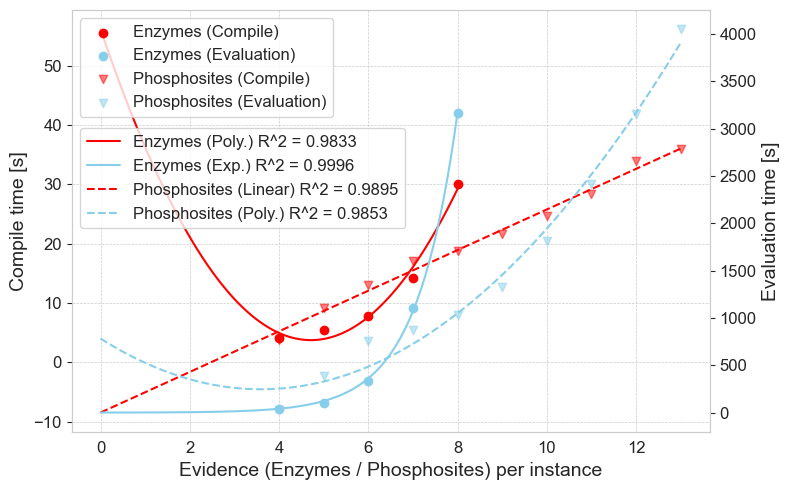

In [17]:
def exp_func(x, a, b):
    return a * np.exp(b * x)

def poly_func(x, *coeffs):
    return np.polyval(coeffs, x)

def linear_func(x, m, c):
    return m * x + c

def compute_r_squared(y_actual, y_predicted):
    residuals = y_actual - y_predicted
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_actual - np.mean(y_actual))**2)
    return 1 - (ss_res / ss_tot)

def custom_fit_plot_b(x_features, y_time_compile, y_time_eval, x_label, degree=2, title='Custom Fit'):

    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(8, 5), dpi=100)  
    
    ax1.set_xlabel(x_label, fontsize=14)
    ax1.set_ylabel('Compile time [s]', fontsize=14)
    ax1.tick_params(axis='both', labelsize=12)
    
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Evaluation time [s]', fontsize=14)  
    ax2.tick_params(axis='y')
    ax2.tick_params(axis='both', labelsize=12)

    custom_labels_line = []
    custom_handles_line = []
    custom_labels_scatter = []
    custom_handles_scatter = []

    for key in x_features.keys():
        if key == 'Enzymes':
            # Compile - Polynomial
            coeffs = np.polyfit(x_features[key], y_time_compile[key], degree)
            feature = x_features[key]
            x_range = np.linspace(0, max(feature), 100)
            line, = ax1.plot(x_range, poly_func(x_range, *coeffs), color='red', linestyle='-', linewidth=1.5)
            r_squared = compute_r_squared(y_time_compile[key], poly_func(feature, *coeffs))
            # label = f'[poly: R^2={r_squared:.4f}]'
            custom_labels_line.append(f'{key} (Poly.) R^2 = {r_squared:.4f}')
            custom_handles_line.append(line)

            # Eval - Exponential
            coeffs, _ = curve_fit(exp_func, x_features[key], y_time_eval[key])
            feature = x_features[key]
            x_range = np.linspace(0, max(feature), 100)
            line, = ax2.plot(x_range, exp_func(x_range, *coeffs), color='skyblue', linestyle='-', linewidth=1.5)
            r_squared = compute_r_squared(y_time_eval[key], exp_func(feature, *coeffs))
            custom_labels_line.append(f'{key} (Exp.) R^2 = {r_squared:.4f}')
            custom_handles_line.append(line)

            # Compile time
            scatter = ax1.scatter(x_features[key], y_time_compile[key], color='red', alpha=1)
            custom_labels_scatter.append(f'{key} (Compile)')
            custom_handles_scatter.append(scatter)

            # Eval time
            scatter = ax2.scatter(x_features[key], y_time_eval[key], color='skyblue', alpha=1)
            custom_labels_scatter.append(f'{key} (Evaluation)')
            custom_handles_scatter.append(scatter)

            
        elif key == 'Phosphosites':
            # Compile - Linear
            coeffs, _ = curve_fit(linear_func, x_features[key], y_time_compile[key])
            feature = x_features[key]
            x_range = np.linspace(0, max(feature), 100)
            line, = ax1.plot(x_range, linear_func(x_range, *coeffs), color='red', linestyle='--', linewidth=1.5)
            r_squared = compute_r_squared(y_time_compile[key], linear_func(feature, *coeffs))
            custom_labels_line.append(f'{key} (Linear) R^2 = {r_squared:.4f}')
            custom_handles_line.append(line)

            # Eval - Polynomial
            coeffs = np.polyfit(x_features[key], y_time_eval[key], degree)
            feature = x_features[key]
            x_range = np.linspace(0, max(feature), 100)
            line, = ax2.plot(x_range, poly_func(x_range, *coeffs), color='skyblue', linestyle='--', linewidth=1.5)
            r_squared = compute_r_squared(y_time_eval[key], poly_func(feature, *coeffs))
            custom_labels_line.append(f'{key} (Poly.) R^2 = {r_squared:.4f}')
            custom_handles_line.append(line)
            
            # Compile time
            scatter = ax1.scatter(x_features[key], y_time_compile[key], color='red', alpha=0.5, marker='v')
            custom_labels_scatter.append(f'{key} (Compile)')
            custom_handles_scatter.append(scatter)

            # Eval time
            scatter = ax2.scatter(x_features[key], y_time_eval[key], color='skyblue', alpha=0.5, marker='v')
            custom_labels_scatter.append(f'{key} (Evaluation)')
            custom_handles_scatter.append(scatter)

    ax1.grid(True, linestyle='--', linewidth=0.5)
    ax2.grid(False)

    # Create the legends for the custom labels
    ax1.legend(custom_handles_scatter, custom_labels_scatter, loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)
    ax2.legend(custom_handles_line, custom_labels_line, loc='upper left', bbox_to_anchor=(0, 0.74), fontsize=12)

    fig.tight_layout()  
    plt.show()

custom_fit_plot_b(x_features_b, y_time_compile_b, y_time_eval_b, 'Evidence (Enzymes / Phosphosites) per instance', title=None)

Plot C

Plot total time vs facts and parameters for enzymes and phosphosites

In [25]:
x_features_c = {'Prob. facts (Enzymes)': n_pfacts, 'Parameters (Enzymes)': n_params,
              'Prob. facts (Phosphosites)': n_pfacts_o2, 'Parameters (Phosphosites)': n_params_o2}
y_time_c = {'Prob. facts (Enzymes)': t_total, 'Parameters (Enzymes)': t_total,
          'Prob. facts (Phosphosites)': t_total_60_o2, 'Parameters (Phosphosites)': t_total_60_o2}

Prob. facts (Enzymes) - Predicted y-value for x = 60: 3202.972098613995s = 53.38286831023325min = 0.8897144718372209h
Parameters (Enzymes) - Predicted y-value for x = 60: 87.45351611131947s = 1.4575586018553246min = 0.02429264336425541h
Prob. facts (Phosphosites) - Predicted y-value for x = 60: 391.5780323336328s = 6.52630053889388min = 0.10877167564823133h
Parameters (Phosphosites) - Predicted y-value for x = 60: 265.8741151180419s = 4.431235251967365min = 0.07385392086612276h


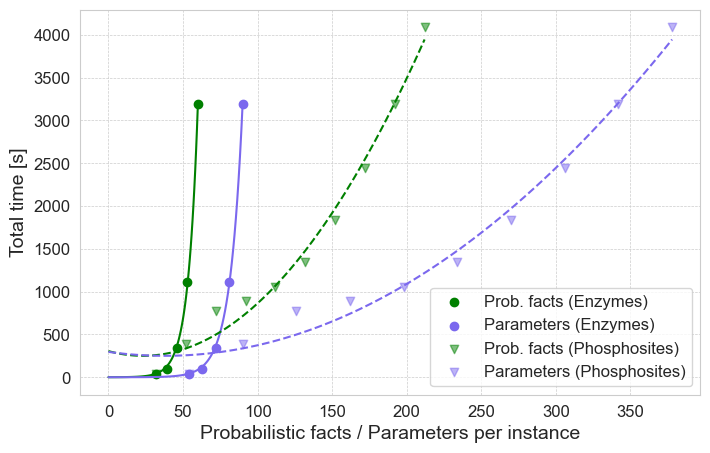

In [29]:
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def poly_func(x, *coeffs):
    return np.polyval(coeffs, x)

def custom_fit_plot_c(x_features, y_time, x_label, y_label, x_predict, degree=2, title='Custom Fit'):
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 5), dpi=100)  # Create a larger figure for better visualization

    for key in x_features.keys():
        feature = x_features[key]
        x_range = np.linspace(0, max(feature), 100)
        
        # Define color based on key
        if "Prob. facts" in key:
            color = 'green'
        elif "Parameters" in key:
            color = 'mediumslateblue'

        if "Enzymes" in key:
            # Exponential fit for enzymes
            initial_guess = [1.0, 0.1]
            params, _ = curve_fit(exponential_func, feature, y_time[key], p0=initial_guess)
            plt.scatter(feature, y_time[key], label=f'{key}', color=color, )
            plt.plot(x_range, exponential_func(x_range, *params), color=color, linestyle = '-', linewidth=1.5)
            y_predict_value = exponential_func(x_predict, *params)
            
        elif "Phosphosites" in key:
            # Polynomial fit for phosphosites
            coeffs, _ = curve_fit(poly_func, feature, y_time[key], p0=[1]*(degree+1))
            plt.scatter(feature, y_time[key], label=f'{key}', color=color, alpha=0.5, marker='v')
            plt.plot(x_range, poly_func(x_range, *coeffs), color=color, linestyle = '--', linewidth=1.5)
            y_predict_value = poly_func(x_predict, *coeffs)
            
        print(f'{key} - Predicted y-value for x = {x_predict}: {y_predict_value}s = {y_predict_value/60}min = {y_predict_value/3600}h')
    
    # Common settings for the plot
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    
    plt.legend(fontsize=12)
    
    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.show()

custom_fit_plot_c(x_features_c, y_time_c, 'Probabilistic facts / Parameters per instance', 'Total time [s]', 60, title=None)

Plot D

Plot facts per evidence / plot combinations per evidence

In [18]:
n_combi = np.array([27, 81, 243, 729, 2187])
n_combi_o2 = np.array([27, 54, 81, 108, 135, 162, 189, 216, 243, 270])

In [19]:
x_features_d = {'Enzymes': n_evidence, 'Phosphosites': n_evidence_o2}
y_params_d = {'Enzymes': n_params, 'Phosphosites': n_params_o2}
y_combis_d = {'Enzymes': n_combi, 'Phosphosites': n_combi_o2}

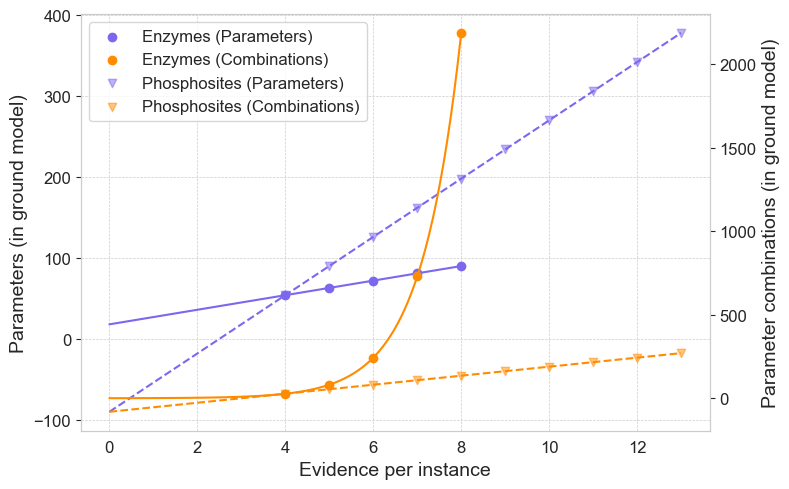

In [20]:
def exp_func(x, a, b):
    return a * np.exp(b * x)

def linear_func(x, m, c):
    return m * x + c

def compute_r_squared(y_actual, y_predicted):
    residuals = y_actual - y_predicted
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_actual - np.mean(y_actual))**2)
    return 1 - (ss_res / ss_tot)

def custom_fit_plot_d(x_features, y_params, y_combis, x_label, degree=2, title='Custom Fit'):

    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(8, 5), dpi=100)  
    
    ax1.set_xlabel(x_label, fontsize=14)
    ax1.set_ylabel('Parameters (in ground model)', fontsize=14)
    ax1.tick_params(axis='both', labelsize=12)
    
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Parameter combinations (in ground model)', fontsize=14)  
    ax2.tick_params(axis='y')
    ax2.tick_params(axis='both', labelsize=12)
    
    custom_labels_line = []
    custom_handles_line = []
    custom_labels_scatter = []
    custom_handles_scatter = []

    for key, color in zip(x_features.keys(), ['r', 'b']):
        if key == 'Enzymes':
            # Params - Linear
            coeffs, _ = curve_fit(linear_func, x_features[key], y_params[key])
            feature = x_features[key]
            x_range = np.linspace(0, max(feature), 100)
            line, = ax1.plot(x_range, linear_func(x_range, *coeffs), color='mediumslateblue', linestyle='-', linewidth=1.5)
            r_squared = compute_r_squared(y_params[key], linear_func(feature, *coeffs))
            custom_labels_line.append(f'{key} (Parameters Linear) R^2={r_squared:.4f}')
            custom_handles_line.append(line)

            # Combis - Exponential
            coeffs, _ = curve_fit(exp_func, x_features[key], y_combis[key])
            feature = x_features[key]
            x_range = np.linspace(0, max(feature), 100)
            line, = ax2.plot(x_range, exp_func(x_range, *coeffs), color='darkorange', linestyle='-', linewidth=1.5)
            r_squared = compute_r_squared(y_combis[key], exp_func(feature, *coeffs))
            custom_labels_line.append(f'{key} (Combinations Exp) R^2={r_squared:.4f}')
            custom_handles_line.append(line)
            
            # Parameters
            scatter = ax1.scatter(x_features[key], y_params[key], color='mediumslateblue')
            custom_labels_scatter.append(f'{key} (Parameters)')
            custom_handles_scatter.append(scatter)

            # Combinations
            scatter = ax2.scatter(x_features[key], y_combis[key], color='darkorange')
            custom_labels_scatter.append(f'{key} (Combinations)')
            custom_handles_scatter.append(scatter)

        elif key == 'Phosphosites':
            # Params - Linear
            coeffs, _ = curve_fit(linear_func, x_features[key], y_params[key])
            feature = x_features[key]
            x_range = np.linspace(0, max(feature), 100)
            line, = ax1.plot(x_range, linear_func(x_range, *coeffs), color='mediumslateblue', linestyle='--', linewidth=1.5)
            r_squared = compute_r_squared(y_params[key], linear_func(feature, *coeffs))
            custom_labels_line.append(f'{key} (Combinations Linear) R^2={r_squared:.4f}')
            custom_handles_line.append(line)

            # Combis - Linear
            coeffs = np.polyfit(x_features[key], y_combis[key], degree)
            feature = x_features[key]
            x_range = np.linspace(0, max(feature), 100)
            line, = ax2.plot(x_range, poly_func(x_range, *coeffs), color='darkorange', linestyle='--', linewidth=1.5)
            r_squared = compute_r_squared(y_combis[key], poly_func(feature, *coeffs))
            custom_labels_line.append(f'{key} (Parameters Linear) R^2={r_squared:.4f}')
            custom_handles_line.append(line)
            
            # Parameters
            scatter = ax1.scatter(x_features[key], y_params[key], color='mediumslateblue', alpha=0.5, marker='v')
            custom_labels_scatter.append(f'{key} (Parameters)')
            custom_handles_scatter.append(scatter)

            # Combinations
            scatter = ax2.scatter(x_features[key], y_combis[key], color='darkorange', alpha=0.5, marker='v')
            custom_labels_scatter.append(f'{key} (Combinations)')
            custom_handles_scatter.append(scatter)

    ax1.grid(True, linestyle='--', linewidth=0.5)
    ax2.grid(False)

    # Create the legends for the custom labels
    ax1.legend(custom_handles_scatter, custom_labels_scatter, loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)

    fig.tight_layout()  
    plt.show()

custom_fit_plot_d(x_features_d, y_params_d, y_combis_d, 'Evidence per instance', title=None)